In [3]:
from IPython.display import display
import re
from cobra.io import read_sbml_model
from dfba import ControlParameter, DfbaModel, ExchangeFlux, KineticVariable
from dfba.plot.matplotlib import *

## Dynamic Flux Based Analysis

Calculating a single number for the isoamyl acetate yield and flux - as we mostly do during this report - gives little information about what the final titres will be.  Traditional flux analysis (often called Flux Balance Analysis or FBA) is static, meaning it provides a snapshot of the metabolic fluxes under a given set of conditions. In contrast, dynamic flux analysis (DFBA) considers how these fluxes change over time. This is crucial for understanding how cells respond to different environmental conditions or genetic modifications.
To get a better idea of how the isoamyl acetate and biomass titres change over time, it can be insightful to mimick real conditions by simulating a simple batch fermentation by DFBA.

The code is run in the following steps:
 - Load libraries and model
 - Calculcate optimal fluxes for biomass and progesterone and adjust the lowerbound for progesterone.
 - Make DFBA model
 - Add Kinetic variables 
 - Add Exchange Fluxes
 - Add right-hand-side expressions (rhs) for kinetic variables
 - Lower/upper bound expressions for exchange fluxes
 - Define initial conditions
 - Run simulation and plot concentrations and trajectories.
 - Investigate relationship between initial glucose concentration and final progesterone titre

In [4]:
from cobra.io import read_sbml_model

In [5]:
model = read_sbml_model("yeast8.xml")
model


Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled


Name,yeastGEM_v8__46__7__46__1
Memory address,0x040a556a080
Number of metabolites,2806
Number of reactions,4131
Number of groups,106
Objective expression,1.0*r_2111 - 1.0*r_2111_reverse_58b69
Compartments,"cell envelope, cytoplasm, extracellular, mitochondrion, nucleus, peroxisome, endoplasmic reticulum, Golgi, lipid particle, vacuole, endoplasmic reticulum membrane, vacuolar membrane, Golgi membrane, mitochondrial membrane"


To ensure that our strain can grow while producing isoamyl acetate, we find the optimal isoamyl acetate productivity and growth rate (see 03_maximum theoretical yield). To simulate the optimal model in steady state, we define a progesterone productivity from the obtained results:

In [6]:
# max growth rate and max progesterone productivity
with model:
    baseline_max_growth = model.optimize().objective_value
    model.objective = model.reactions.r_1180
    baseline_max_production = model.optimize().objective_value
print(f"Maximum growth rate: {baseline_max_growth} gDW/h")
print(f"Maximum isoamyl acetate production: {baseline_max_production} mmol/gDW*h")

Maximum growth rate: 0.08192821423406454 gDW/h
Maximum isoamyl acetate production: 0.556403433387518 mmol/gDW*h


In [7]:
# growth and isoamyl acetate productivity when both are set to be objective
with model:
    model.objective = {model.reactions.get_by_id('r_2111'): baseline_max_production, 
                    model.reactions.get_by_id('r_1180'): baseline_max_growth} # objective is to lead flux through the reaction producing progesterone top maximise production
    solution = model.optimize()
    growth = solution.fluxes['r_2111']
    isoamyl_acetate = solution.fluxes['r_1180'] 
    o_uptake = solution.fluxes['r_1992']
    glc_uptake = solution.fluxes['r_1714']

print("For model with biomass production and isoamyl acetate production set as an ojective:")
print(f"Max growth rate: {growth} gDW/h")
print(f"Max isoamyl acetate yield: {isoamyl_acetate} mmol/gDW*h")

For model with biomass production and isoamyl acetate production set as an ojective:
Max growth rate: 0.032358322856891095 gDW/h
Max isoamyl acetate yield: 0.36903040785530083 mmol/gDW*h


Now we have calculated the optimal fluxes for isoamyl acetate and biomass when they are both set to the objective for the model. Unfortunately, this DFBA simulation does not work when two reactions are set as the objective. 
Therefore, we chose to biomass as the objective and then force the isoa flux to the value ~0.36 gDW/h, as calculated above.

In [8]:
model.reactions.r_1180.lower_bound = growth
print(f"Setting isoamyl acetate production to: {isoamyl_acetate} mmol/gDW*h")

Setting isoamyl acetate production to: 0.36903040785530083 mmol/gDW*h


In [9]:
model.solver = "glpk"
dfba_model = DfbaModel(model)

In [10]:
# Defining kinetic variables
# These variables represent concentrations of these components that can change dynamically over the course of the simulation.
X = KineticVariable("Biomass")
V = KineticVariable("Volume")
Gluc = KineticVariable("Glucose")
Isoa = KineticVariable("IsoamylAcetate")

# The kinetic variables are added to the DFBA model, which will be part of the dynamic simulation.
dfba_model.add_kinetic_variables([X, Gluc, Isoa, V])

In [11]:
# Exchange fluxes
# The rates at which these substances are produced or consumed by the cell.
mu = ExchangeFlux("r_2111")
v_G = ExchangeFlux("r_1714")
v_O = ExchangeFlux("r_1992")
v_I = ExchangeFlux("r_1180")
                   
# The exchange fluxes are added to the DFBA model. These will dictate the dynamics of how substances are exchanged with the environment.                   
dfba_model.add_exchange_fluxes([mu, v_G, v_O, v_I])

In [12]:
Vgmax = 8.5
Kg = 0.5
D = 0.044
Gin = 10.0
Vomax = 8.0
Oxy = ControlParameter("Oxygen", [7.7], [Vomax, 0.0])

In [13]:
dfba_model.add_rhs_expression("Volume", D)
dfba_model.add_rhs_expression("Biomass", mu * X - D * X / V)
dfba_model.add_rhs_expression("Glucose", v_G * X + D * (Gin - Gluc) / V)
dfba_model.add_rhs_expression("IsoamylAcetate", v_I * X - D * Isoa / V)


In [14]:
# add lower/upper bound expressions for exchange fluxes in dfba_model together
# with expression that must be non-negative for correct evaluation of bounds
dfba_model.add_exchange_flux_lb("r_1714", Vgmax * (Gluc / (Kg + Gluc)), Gluc)
dfba_model.add_exchange_flux_lb("r_1992", Oxy, control_parameters=Oxy)


In [15]:
# add initial conditions for kinetic variables in dfba_model biomass (gDW/L),
# metabolites (g/L)
dfba_model.add_initial_conditions(
    {
        "Volume": 0.5,
        "Biomass": 0.05,
        "Glucose": 10.0,
        "IsoamylAcetate": 0.0,
    }
)

# simulate model across interval t = [0.0,16.0](hours) with outputs for plotting every 0.1h
concentrations, trajectories = dfba_model.simulate(0.0, 16.0, 0.1, ["r_2111", "r_1992", "r_1714","r_1180"])


GLPK Simplex Optimizer 5.0
2806 rows, 8262 columns, 31164 non-zeros
      0: obj =   3.083301471e-01 inf =   3.033e-01 (5)
     40: obj =   2.993197645e-01 inf =   6.802e-16 (0)
*   138: obj =   3.934046390e-01 inf =   5.156e-15 (0)
OPTIMAL LP SOLUTION FOUND


Final Run Statistics: 

Number of steps                    = 36
Number of residual evaluations     = 128
Number of Jacobian evaluations     = 19
Number of nonlinear iterations     = 62
Number of error test failures      = 2
Number of nonlinear conv. failures = 0
Number of root fn. evaluations     = 117

GLPK Simplex Optimizer 5.0
2806 rows, 8262 columns, 31164 non-zeros
    138: obj =   3.018693189e-01 inf =   1.452e-03 (2)
    147: obj =   3.018206820e-01 inf =   1.434e-15 (0)
*   198: obj =   3.018438368e-01 inf =   2.555e-16 (0) 1
OPTIMAL LP SOLUTION FOUND

Final Run Statistics: 

Number of steps                    = 0
Number of residual evaluations     = 0
Number of Jacobian evaluations     = 15
Number of nonlinear iterations

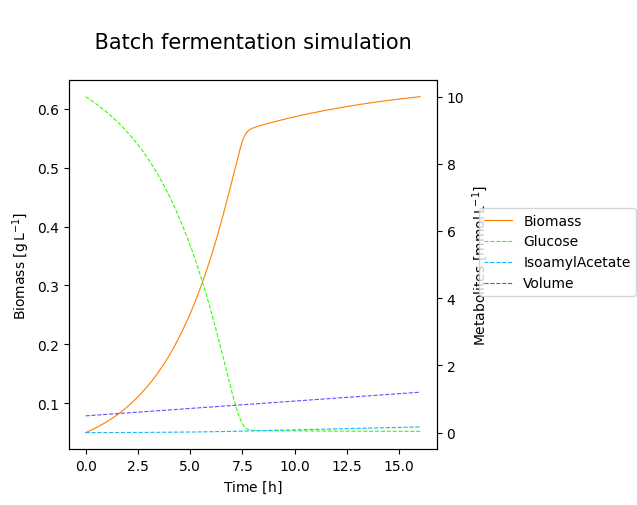

In [16]:
# plotting concentration in steady state
plot_concentrations(concentrations)
plt.title(" \n Batch fermentation simulation \n", size=15)
plt.savefig('Bacth_fermentation_simul.png',bbox_inches='tight')

In [17]:
concentrations.iloc[::10]

,time,Biomass,Glucose,IsoamylAcetate,Volume
0,0.0,0.050000,10.000000,0.000000,0.500
10,1.0,0.068208,9.542307,0.001832,0.544
20,2.0,0.094082,8.940247,0.004250,0.588
30,3.0,0.130430,8.135409,0.007497,0.632
40,4.0,0.181183,7.048867,0.011917,0.676
50,5.0,0.251847,5.575884,0.017996,0.720
60,6.0,0.348992,3.610455,0.026369,0.764
70,7.0,0.477616,1.198999,0.037890,0.808
80,8.0,0.567263,0.066990,0.052849,0.852
90,9.0,0.577700,0.055718,0.068335,0.896


Text(0.5, 1.0, '\n Fluxes for batch fermentation simulation \n')

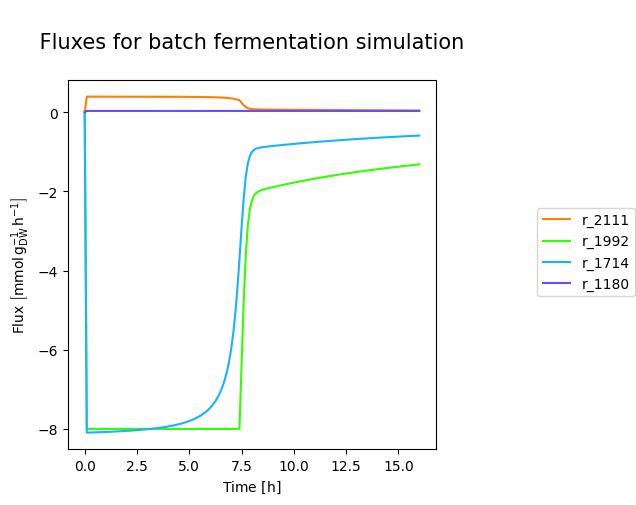

In [18]:
# Plotting fluxes at steady state
plot_trajectories(trajectories)
plt.title("\n Fluxes for batch fermentation simulation \n", size=15)